In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import math
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [108]:
# Reading the Dataset and dropping the un-necessary columns

df = pd.read_csv("couriers_target_assignment_data.csv")
df = df.drop(['CourierId','runSheetTime','StartTime'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28865 entries, 0 to 28864
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        28865 non-null  object 
 1   RouteCode                   28865 non-null  int64  
 2   IdleTimeMinutes             22451 non-null  float64
 3   stopsDistance_median        21375 non-null  float64
 4   OutForDeliveryProductType1  16304 non-null  float64
 5   OutForDeliveryProductType2  17387 non-null  float64
 6   OutForDeliveryProductType3  11787 non-null  float64
 7   OutForDeliveryProductType4  11442 non-null  float64
 8   OutForDeliveryProductType5  24378 non-null  float64
 9   FirstOFD                    24220 non-null  float64
 10  TotalWeight                 24320 non-null  float64
 11  TotalOrderValue             18926 non-null  float64
 12  PlannedCollection           19738 non-null  float64
 13  DeliveryStops               239

A lot of missing values can be seen in almost all the columns. These missing values has to be handled efficiently to have a better preditions over fair target. There are two features namely PlannedCollection and CollectionStops, both are saying the same thing so the missing values in CollectionStops are directly retrieved from PlannedCollection. And this decision can also be made from the below scatter plot.

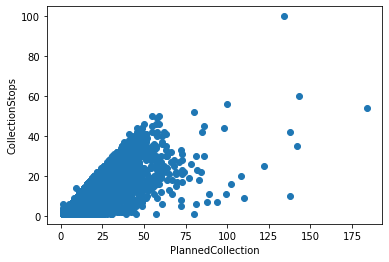

In [109]:
# Scatter Plot between PlannedCollection and CollectionStops

plt.scatter(df['PlannedCollection'],df['CollectionStops'])
plt.xlabel('PlannedCollection')
plt.ylabel('CollectionStops')
plt.show()

In [110]:
# Filling the missing values in CollectionStops using PlannedCollection and dropping the rows which have null values in 
# both CollectionStops and DeliveryStops

df.CollectionStops.fillna(df.PlannedCollection,inplace=True)
df = df.dropna(subset=['CollectionStops','DeliveryStops'],how='all').reset_index()
df = df.drop('index',axis=1)
df

,Date,RouteCode,IdleTimeMinutes,stopsDistance_median,OutForDeliveryProductType1,OutForDeliveryProductType2,OutForDeliveryProductType3,OutForDeliveryProductType4,OutForDeliveryProductType5,FirstOFD,TotalWeight,TotalOrderValue,PlannedCollection,DeliveryStops,CollectionStops
0,2020-03-02,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0
1,2020-03-02,260,115.0,560.144616,22.0,8.0,NaN,NaN,13.0,34.0,148.098,2349.622,13.0,30.0,11.0
2,2020-03-02,463,94.0,4936.342118,NaN,NaN,NaN,15.0,0.0,13.0,7.500,NaN,NaN,14.0,NaN
3,2020-03-02,615,39.0,266.148889,4.0,3.0,1.0,24.0,8.0,34.0,17.543,190.717,13.0,33.0,12.0
4,2020-03-02,313,29.0,217.069458,8.0,8.0,1.0,1.0,31.0,41.0,56.976,1859.955,23.0,31.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25395,2020-05-31,682,371.0,755.909297,17.0,12.0,7.0,16.0,14.0,52.0,72.940,3788.241,2.0,30.0,2.0
25396,2020-05-31,259,61.0,131.257694,12.0,88.0,12.0,NaN,5.0,93.0,237.003,6643.466,35.0,96.0,20.0
25397,2020-05-31,520,75.0,262.801863,4.0,42.0,4.0,NaN,27.0,62.0,63.658,1363.646,NaN,56.0,NaN
25398,2020-05-31,445,10.0,455.911613,3.0,11.0,1.0,39.0,22.0,62.0,47.399,847.695,11.0,58.0,3.0


In [111]:
# Filling the missing values in DeliveryStops and CollectionStops using RouteCode

df.DeliveryStops = df.groupby('RouteCode')['DeliveryStops'].transform(lambda x: x.fillna(x.mean()))
df.CollectionStops = df.groupby('RouteCode')['CollectionStops'].transform(lambda x: x.fillna(x.mean()))
df.DeliveryStops = df.DeliveryStops.round()
df.CollectionStops = df.CollectionStops.round()

In [112]:
df[['CollectionStops','DeliveryStops']].isnull().sum()

CollectionStops    1452
DeliveryStops       108
dtype: int64

In [113]:
df = df.dropna(subset=['CollectionStops','DeliveryStops'])
df[['CollectionStops','DeliveryStops']].isnull().sum()

CollectionStops    0
DeliveryStops      0
dtype: int64

In [114]:
df['Fair Target'] = df.DeliveryStops + df.CollectionStops
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23840 entries, 0 to 25399
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23840 non-null  object 
 1   RouteCode                   23840 non-null  int64  
 2   IdleTimeMinutes             21352 non-null  float64
 3   stopsDistance_median        21128 non-null  float64
 4   OutForDeliveryProductType1  15998 non-null  float64
 5   OutForDeliveryProductType2  17139 non-null  float64
 6   OutForDeliveryProductType3  11743 non-null  float64
 7   OutForDeliveryProductType4  11407 non-null  float64
 8   OutForDeliveryProductType5  22582 non-null  float64
 9   FirstOFD                    22456 non-null  float64
 10  TotalWeight                 22539 non-null  float64
 11  TotalOrderValue             18536 non-null  float64
 12  PlannedCollection           19630 non-null  float64
 13  DeliveryStops               238

In [115]:
#Finding Correlation between the features

df.corr()

,RouteCode,IdleTimeMinutes,stopsDistance_median,OutForDeliveryProductType1,OutForDeliveryProductType2,OutForDeliveryProductType3,OutForDeliveryProductType4,OutForDeliveryProductType5,FirstOFD,TotalWeight,TotalOrderValue,PlannedCollection,DeliveryStops,CollectionStops,Fair Target
RouteCode,1.000000,0.104702,0.044465,0.093198,0.023651,0.020659,0.068263,-0.212610,0.011353,0.015612,0.053827,-0.230668,0.011253,-0.196878,-0.049549
IdleTimeMinutes,0.104702,1.000000,-0.023405,0.191277,-0.002633,-0.058198,-0.018017,-0.069249,0.015444,0.041406,0.076340,-0.114499,0.007915,-0.120055,-0.029146
stopsDistance_median,0.044465,-0.023405,1.000000,0.025970,-0.219325,-0.179407,-0.153313,0.014113,-0.375279,0.040234,0.099284,-0.110018,-0.489540,-0.122796,-0.493816
OutForDeliveryProductType1,0.093198,0.191277,0.025970,1.000000,0.183489,-0.127507,-0.500723,-0.117068,0.232578,0.122264,0.434834,-0.220973,0.201567,-0.211528,0.111071
OutForDeliveryProductType2,0.023651,-0.002633,-0.219325,0.183489,1.000000,0.503579,-0.527127,-0.034649,0.931210,0.159804,0.541595,-0.021120,0.224711,-0.003615,0.206300
OutForDeliveryProductType3,0.020659,-0.058198,-0.179407,-0.127507,0.503579,1.000000,-0.205334,-0.098417,0.494923,0.037163,0.101662,-0.025254,0.487718,0.002794,0.454070
OutForDeliveryProductType4,0.068263,-0.018017,-0.153313,-0.500723,-0.527127,-0.205334,1.000000,-0.465021,0.341303,-0.132970,-0.443540,-0.317189,0.357595,-0.291556,0.259014
OutForDeliveryProductType5,-0.212610,-0.069249,0.014113,-0.117068,-0.034649,-0.098417,-0.465021,1.000000,0.138192,-0.005779,-0.039087,0.429990,0.010208,0.466136,0.143815
FirstOFD,0.011353,0.015444,-0.375279,0.232578,0.931210,0.494923,0.341303,0.138192,1.000000,0.125251,0.475295,0.070322,0.456048,0.054416,0.441187
TotalWeight,0.015612,0.041406,0.040234,0.122264,0.159804,0.037163,-0.132970,-0.005779,0.125251,1.000000,0.327886,-0.019977,0.022122,-0.029705,0.012052


<AxesSubplot:>

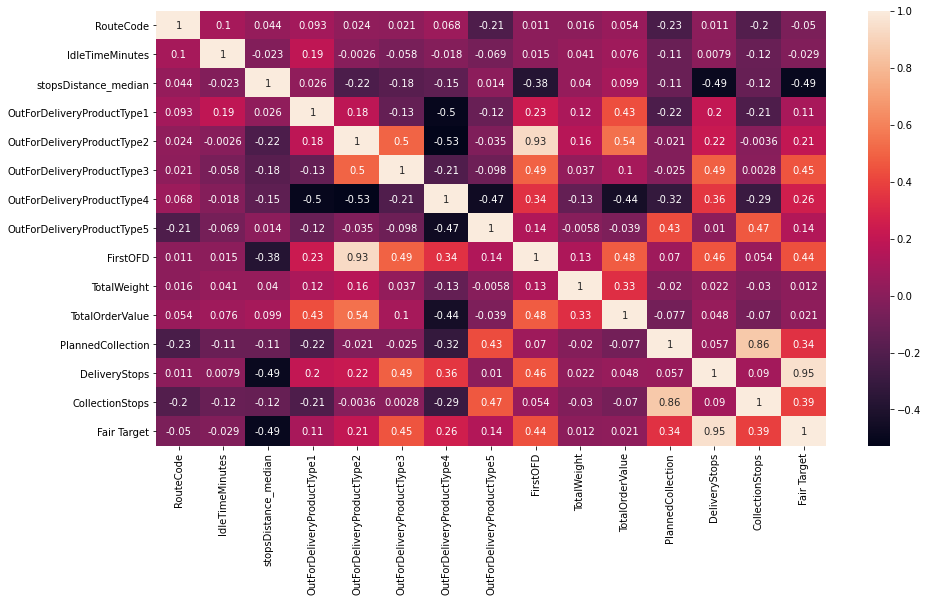

In [116]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True)

In [117]:
# KNN Imputation for OutForDeliveryProductType1 to Type5

imputer = KNNImputer(n_neighbors=4)
df[['OutForDeliveryProductType1','OutForDeliveryProductType2','OutForDeliveryProductType3','OutForDeliveryProductType4','OutForDeliveryProductType5']] = imputer.fit_transform(df[['OutForDeliveryProductType1','OutForDeliveryProductType2','OutForDeliveryProductType3','OutForDeliveryProductType4','OutForDeliveryProductType5']]).round()

In [118]:
x = df['OutForDeliveryProductType2']
y = df['FirstOFD']

new_df = pd.DataFrame([x,y]).transpose()
new_df = new_df.dropna()

x = new_df.iloc[:,0]
y = new_df.iloc[:,1]
x = x.values.reshape((len(x),1))
y = y.values.reshape((len(y),1))

In [119]:
# Imputing the missing values in FirstOFD using linear regression fitted on OutForDeliveryProductType2 and FirstOFD

lin_reg = LinearRegression()
lin_reg.fit(x,y)
w0 = lin_reg.intercept_
w1 = lin_reg.coef_

df.FirstOFD.fillna( 36.80349935+0.19959758 * df.OutForDeliveryProductType2,inplace=True)
df.FirstOFD = df.FirstOFD.round()

In [120]:
df = df.drop(['DeliveryStops','CollectionStops','RouteCode'],axis=1)
df = df.dropna().reset_index()
df.shape

(14506, 14)

In [121]:
# Adding the essential features for the model creation

df['OFDProductType1Ratio'] = df['OutForDeliveryProductType1'] / (df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'] + df['PlannedCollection'])
df['OFDProductType2Ratio'] = df['OutForDeliveryProductType2'] / (df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'] + df['PlannedCollection'])
df['OFDProductType3Ratio'] = df['OutForDeliveryProductType3'] / (df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'] + df['PlannedCollection'])
df['OFDProductType4Ratio'] = df['OutForDeliveryProductType4'] / (df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'] + df['PlannedCollection'])
df['OFDProductType5Ratio'] = df['OutForDeliveryProductType5'] / (df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'] + df['PlannedCollection'])
df[ 'FirstOFD / Total OFD']=df['FirstOFD']/(df['OutForDeliveryProductType1'] + df['OutForDeliveryProductType2'] + df['OutForDeliveryProductType3'] + df['OutForDeliveryProductType4'] + df['OutForDeliveryProductType5'])

In [122]:
df=df.drop(['OutForDeliveryProductType1','OutForDeliveryProductType2','OutForDeliveryProductType3','OutForDeliveryProductType4','OutForDeliveryProductType5','PlannedCollection','FirstOFD','index'],axis=1)

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'OFDProductType1Ratio'),
  Text(2, 0, 'OFDProductType2Ratio'),
  Text(3, 0, 'OFDProductType3Ratio'),
  Text(4, 0, 'OFDProductType4Ratio'),
  Text(5, 0, 'OFDProductType5Ratio'),
  Text(6, 0, 'FirstOFD / Total OFD')])

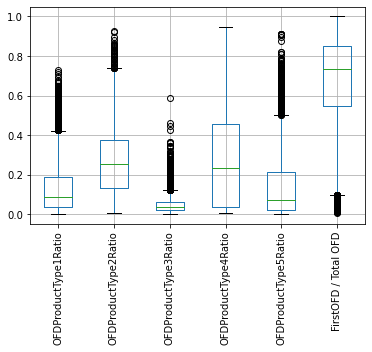

In [123]:
# Drawing the boxplot to check the outliers

boxplot = df.boxplot(column=['OFDProductType1Ratio','OFDProductType2Ratio','OFDProductType3Ratio','OFDProductType4Ratio','OFDProductType5Ratio','FirstOFD / Total OFD'])
plt.xticks(rotation=90)

In [124]:
# Removing the outliers keeping the z-score between -3 and 3

dff = df.copy()
dff = dff.drop(['Date'],axis=1)
dff = dff[(np.abs(stats.zscore(dff)) < 3).all(axis=1)]
dff

,IdleTimeMinutes,stopsDistance_median,TotalWeight,TotalOrderValue,Fair Target,OFDProductType1Ratio,OFDProductType2Ratio,OFDProductType3Ratio,OFDProductType4Ratio,OFDProductType5Ratio,FirstOFD / Total OFD
0,115.0,560.144616,148.098,2349.622,41.0,0.354839,0.129032,0.048387,0.048387,0.209677,0.693878
1,39.0,266.148889,17.543,190.717,45.0,0.075472,0.056604,0.018868,0.452830,0.150943,0.850000
2,29.0,217.069458,56.976,1859.955,52.0,0.111111,0.111111,0.013889,0.013889,0.430556,0.836735
4,53.0,785.582966,12.091,331.101,29.0,0.190476,0.047619,0.023810,0.119048,0.357143,0.741935
5,38.0,354.584300,19.330,273.563,52.0,0.081967,0.016393,0.049180,0.557377,0.000000,0.837209
...,...,...,...,...,...,...,...,...,...,...,...
14497,87.0,343.790655,19.564,487.695,44.0,0.044776,0.268657,0.044776,0.029851,0.313433,0.893617
14499,57.0,193.341591,141.479,1427.564,53.0,0.096154,0.326923,0.019231,0.403846,0.038462,0.500000
14500,65.0,214.973907,90.264,1927.088,69.0,0.051020,0.500000,0.061224,0.142857,0.102041,0.761905
14501,36.0,253.434609,110.735,3280.805,70.0,0.069307,0.534653,0.039604,0.217822,0.049505,0.891304


(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'OFDProductType1Ratio'),
  Text(2, 0, 'OFDProductType2Ratio'),
  Text(3, 0, 'OFDProductType3Ratio'),
  Text(4, 0, 'OFDProductType4Ratio'),
  Text(5, 0, 'OFDProductType5Ratio'),
  Text(6, 0, 'FirstOFD / Total OFD')])

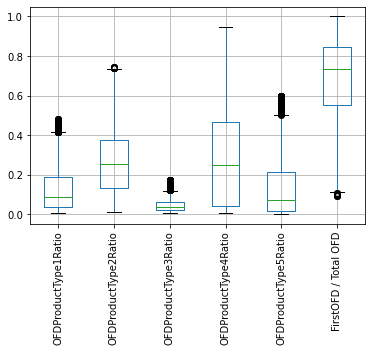

In [125]:
# Boxplot after handling the few outliers

boxplot = dff.boxplot(column=['OFDProductType1Ratio','OFDProductType2Ratio','OFDProductType3Ratio','OFDProductType4Ratio','OFDProductType5Ratio','FirstOFD / Total OFD'])
plt.xticks(rotation=90)

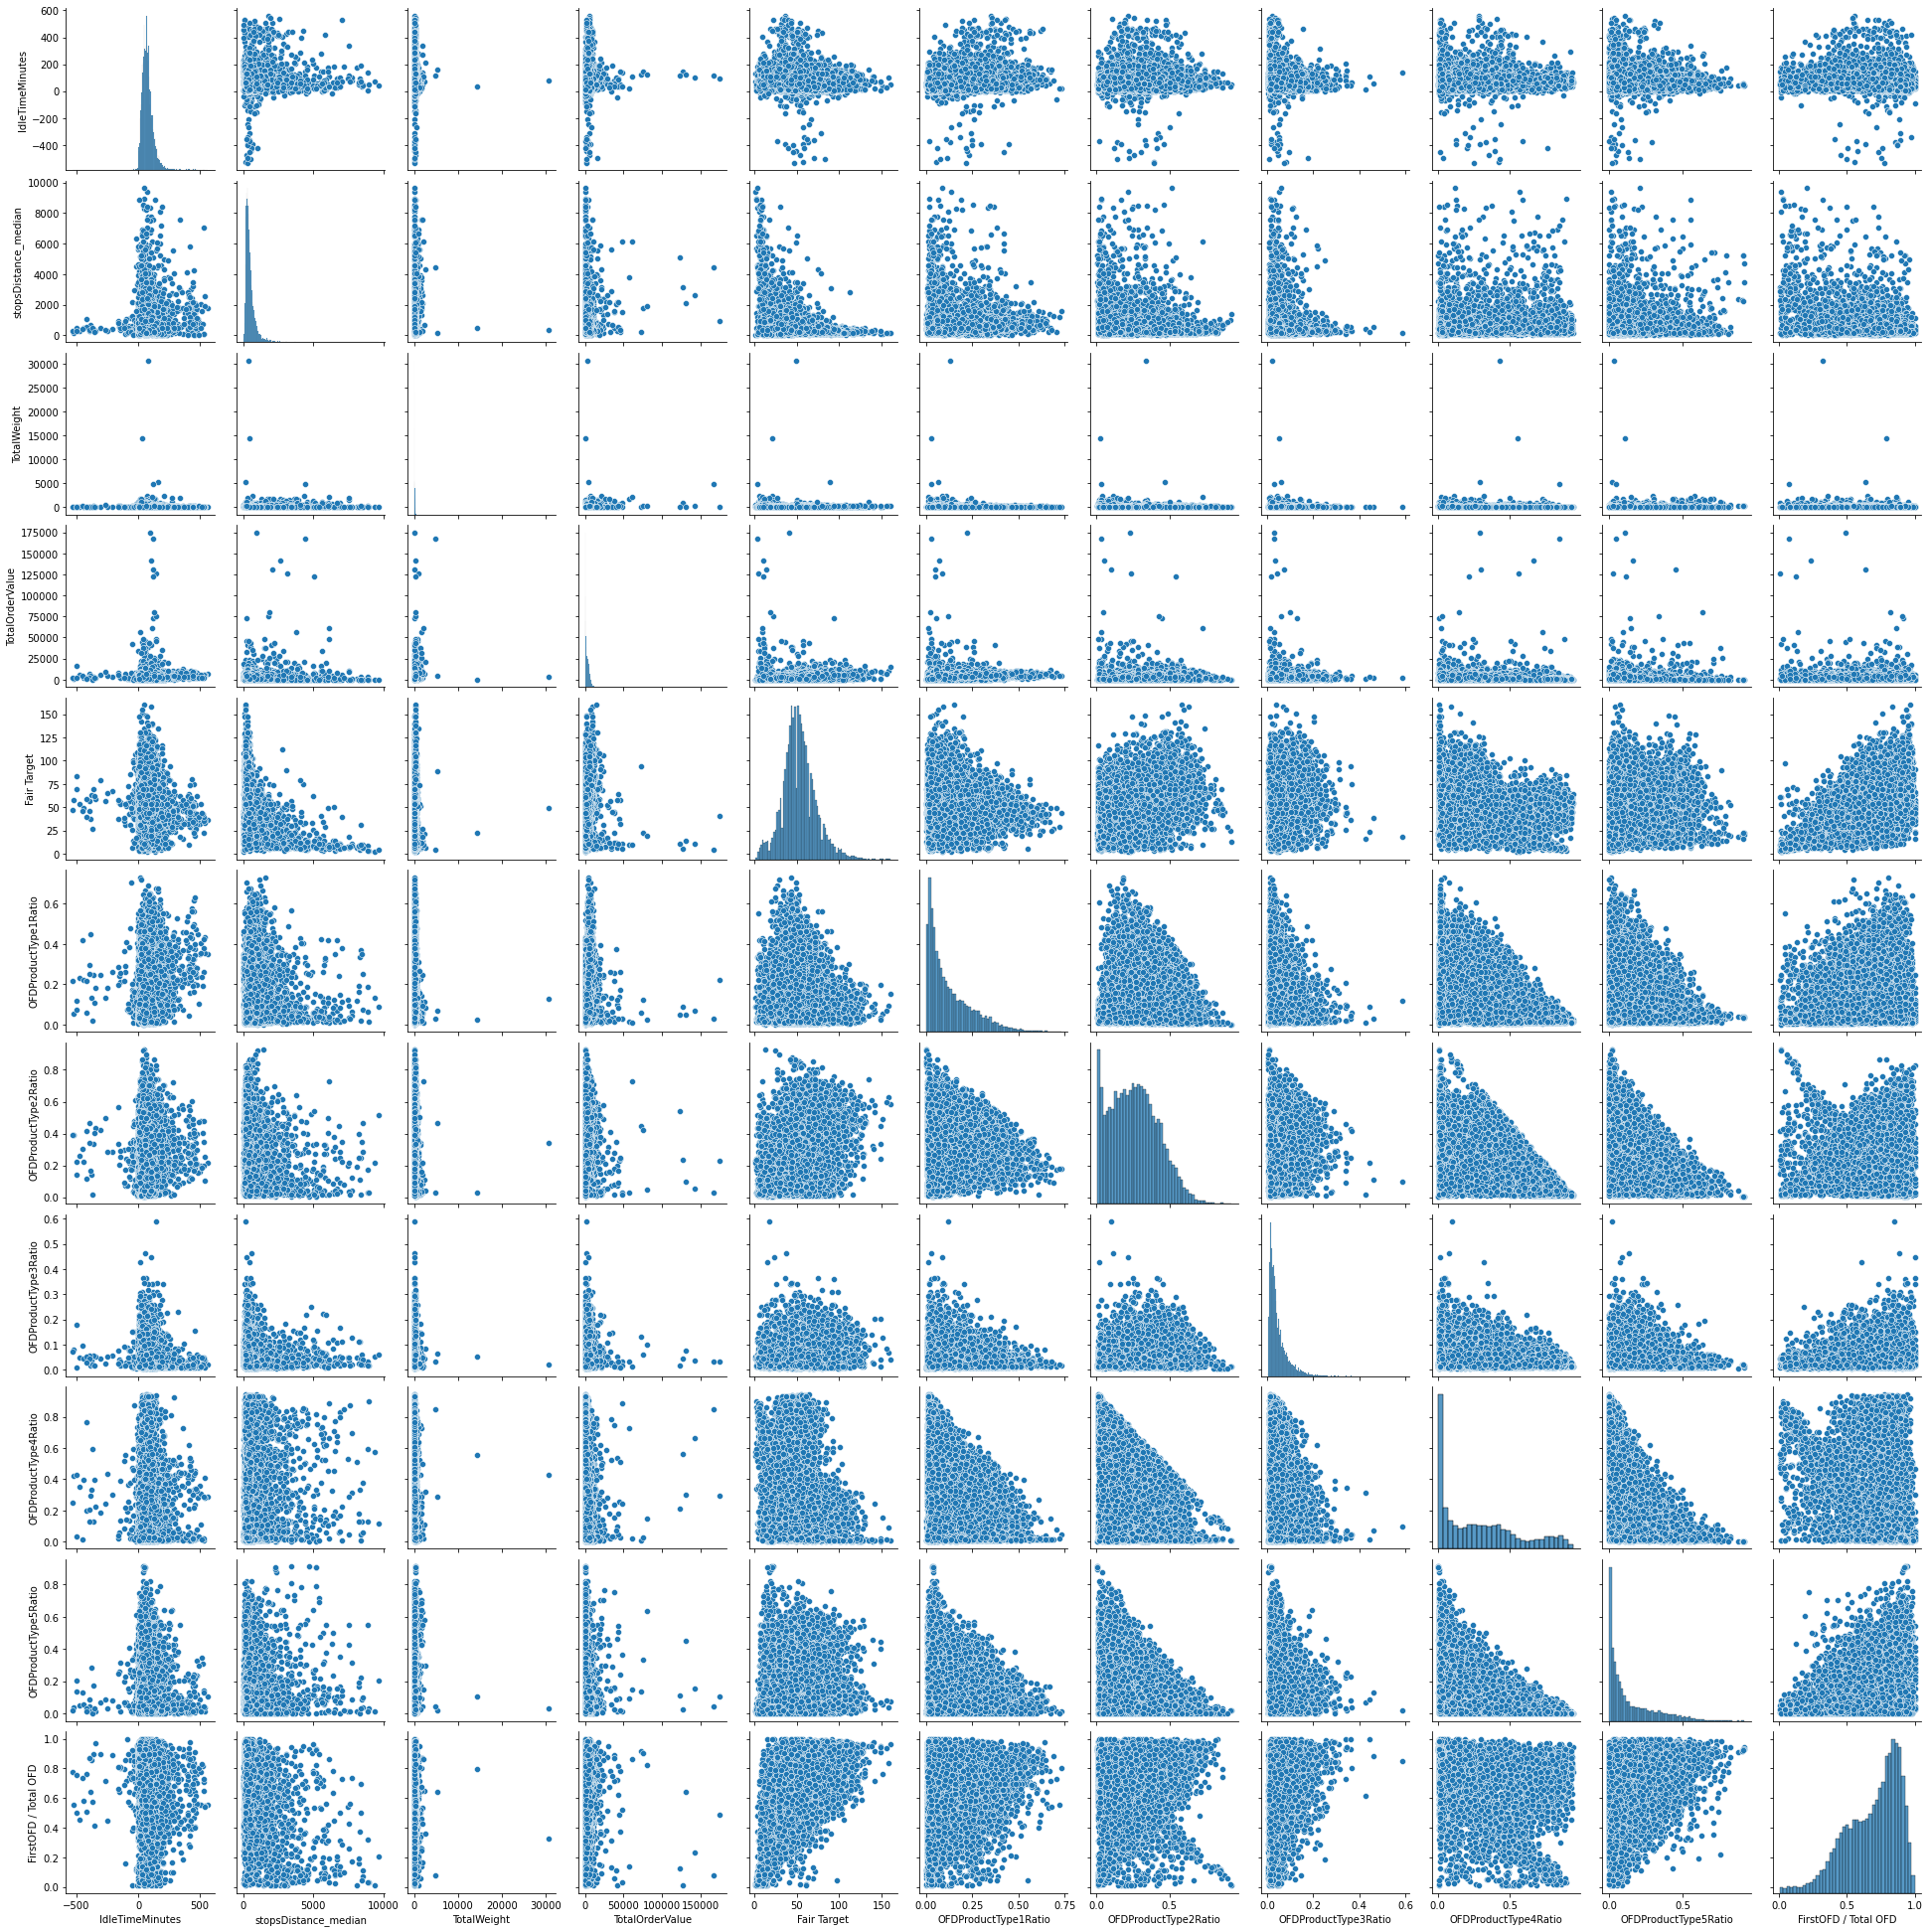

In [126]:
# Pairplot to observe the relation between the features graphically and the each feature distribution

sns.pairplot(df)

<AxesSubplot:title={'center':'Mean'}, xlabel='month'>

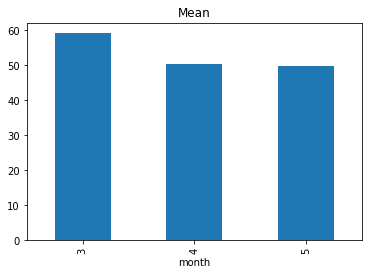

In [127]:
# Month wise barchart for Fair Target

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['month'] = df['Date'].dt.month
grouped = df.groupby('month')['Fair Target']
grouped.mean().plot.bar(title = 'Mean')

In [128]:
# Applying the standardscalar to keep every feature in the same range

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dff.drop(['Fair Target'],axis=1))

In [129]:
X=dff.drop(['Fair Target'],axis=1)
Y=dff.loc[:,['Fair Target']]

In [130]:
# Splitting the data into train and test splits

x_train, x_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Multiple Linear Regression

In [131]:
regr2=sm.OLS(y_train,x_train)
model=regr2.fit()
print("Train RMSE by MLR:",math.sqrt(mean_squared_error(y_train,model.predict(x_train))))
print("Test RMSE by MLR:",math.sqrt(mean_squared_error(y_test,model.predict(x_test))))

print(model.summary())

Train RMSE by MLR: 13.474741035129977
Test RMSE by MLR: 13.259981576330757
                                 OLS Regression Results                                
Dep. Variable:            Fair Target   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                          1.761e+04
Date:                Fri, 09 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:52:27   Log-Likelihood:                         -42473.
No. Observations:               10566   AIC:                                  8.497e+04
Df Residuals:                   10556   BIC:                                  8.504e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err   

In [132]:
dff2 = dff.copy()

X=dff2.drop(['Fair Target','OFDProductType1Ratio'],axis=1)
Y=dff2.loc[:,['Fair Target']]

In [133]:
# Splitting the data into train and test splits

x_train, x_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [134]:
regr2=sm.OLS(y_train,x_train)
model=regr2.fit()
print("Train RMSE by MLR:",math.sqrt(mean_squared_error(y_train,model.predict(x_train))))
print("Test RMSE by MLR:",math.sqrt(mean_squared_error(y_test,model.predict(x_test))))

print(model.summary())

Train RMSE by MLR: 13.653708326047408
Test RMSE by MLR: 13.466267550067688
                                 OLS Regression Results                                
Dep. Variable:            Fair Target   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                          1.902e+04
Date:                Fri, 09 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:52:27   Log-Likelihood:                         -42612.
No. Observations:               10566   AIC:                                  8.524e+04
Df Residuals:                   10557   BIC:                                  8.531e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err   

## KNN REGRESSION

In [135]:
X=dff.drop(['Fair Target'],axis=1)
Y=dff.loc[:,['Fair Target']]

x_train, x_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [136]:
error =[]
scores_list = {}
for k in range(1,60):
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    z=math.sqrt(mean_squared_error(y_test,y_pred))
    error.append(z)

Text(0, 0.5, 'RMSE')

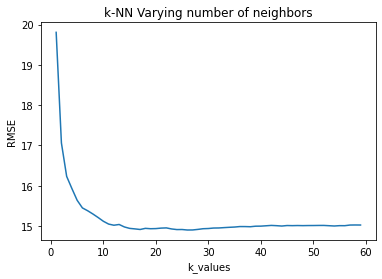

In [137]:
rmse=np.array(error)
k=np.arange(1,60)
plt.plot(k,rmse)
plt.title('k-NN Varying number of neighbors')
plt.xlabel('k_values')
plt.ylabel('RMSE')

In [138]:
r2score=make_scorer(r2_score)
knn=KNeighborsRegressor(n_neighbors=10)
knn.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=10)

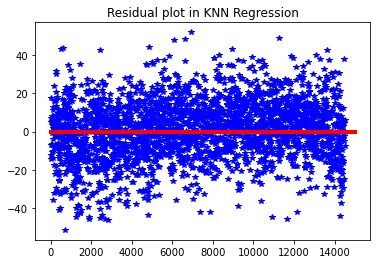

In [139]:
y_pred=knn.predict(x_test)
plt.plot(y_pred-y_test,'b*')
plt.plot([0,15000],[0,0],color='red',linewidth=4)
plt.title('Residual plot in KNN Regression')
plt.show()

In [140]:
print("Train RMSE with opt k:",math.sqrt(mean_squared_error(y_train,knn.predict(x_train))))
print("Test RMSE with opt_k:",math.sqrt(mean_squared_error(y_test,knn.predict(x_test))))

Train RMSE with opt k: 13.624436422848554
Test RMSE with opt_k: 15.118272178772976


## Decision Tree

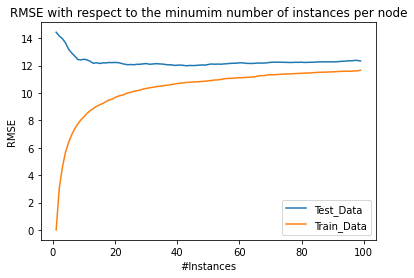

In [141]:
test_RMSE = []
train_RMSE = []
diff_test_train_RMSE = []
for i in range(1, 100):
    dt=DecisionTreeRegressor(min_samples_leaf= i)
    dt.fit(x_train,y_train)
    dt.score(x_train,y_train)
    y_pred_dttr=dt.predict(x_train)
    y_pred_dtte=dt.predict(x_test)
    test_RMSE.append(math.sqrt(mean_squared_error(y_test,y_pred_dtte)))
    train_RMSE.append(math.sqrt(mean_squared_error(y_train,y_pred_dttr)))

fig = plt.figure()
ax0 = fig.add_subplot(111) 
ax0.plot(range(1,100),test_RMSE,label='Test_Data')
ax0.plot(range(1,100),train_RMSE,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

In [142]:
dt=DecisionTreeRegressor(min_samples_leaf= 40)
dt.fit(x_train,y_train)
dt.score(x_train,y_train)
y_pred_dttr=dt.predict(x_train)
y_pred_dtte=dt.predict(x_test)


print('Test RMSE: ',math.sqrt(mean_squared_error(y_test,y_pred_dtte)))
print('Train RMSE: ',math.sqrt(mean_squared_error(y_train,y_pred_dttr)))

Test RMSE:  12.030814769326728
Train RMSE:  10.688040707684753
